In [3]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers

Tensorflow version: 2.8.1


In [4]:
print('Available devices:', tf.config.list_physical_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3*1024)]
    )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2022-11-13 23:03:23.653537: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-13 23:03:23.653577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: beldroega-Inspiron-7572
2022-11-13 23:03:23.653587: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: beldroega-Inspiron-7572
2022-11-13 23:03:23.653741: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-11-13 23:03:23.653769: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-11-13 23:03:23.653777: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3


## Dataset

Fashion-MNIST is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

Dataset Information:

- You should respect the following traininig/test split: 60,000 training examples, and 10,000 test examples. Avoid overfitting.

- The data is available at:
https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip:
‘train’ folder (fashion-mnist train.csv.zip) + ‘test’ folder (fashion-mnist test.csv.zip).

  - You can also download the data by the framework you are using.

- Each training and test example is assigned to one of the following labels: 0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot.
- Each row is a separate image. Column 1 is the class label. The remaining columns are pixel numbers (784 total). Each value is the darkness of the pixel (1 to 255). Dataset was converted to CSV with this script: https://pjreddie.com/projects/mnist-in-csv.

In [3]:
# Download Fashion-MNIST
df = pd.read_csv("./fashion-mnist_train.csv.zip").sample(frac=1, random_state=123)
n_sample, n_feature = df.shape
train_df = df[:int(n_sample*0.8)]
valid_df = df[int(n_sample*0.8):]
testt_df = pd.read_csv("./fashion-mnist_test.csv.zip").sample(frac=1, random_state=123)

class_names = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

print('train shape {}, validation shape {}, teste shape {}'.format(train_df.shape, valid_df.shape, testt_df.shape))

train shape (48000, 785), validation shape (12000, 785), teste shape (10000, 785)


In [4]:
BATCH_SIZE = 16

samples = train_df
target  = samples.pop('label')
train_dataset = tf.data.Dataset.from_tensor_slices((samples.values.reshape(-1, 28, 28), target.values))
train_dataset = train_dataset.batch(BATCH_SIZE)

samples = valid_df
target  = samples.pop('label')
validation_dataset = tf.data.Dataset.from_tensor_slices((samples.values.reshape(-1, 28, 28), target.values))
validation_dataset = validation_dataset.batch(BATCH_SIZE)

samples = testt_df
target  = samples.pop('label')
test_dataset = tf.data.Dataset.from_tensor_slices((samples.values.reshape(-1, 28, 28), target.values))
test_dataset = test_dataset.batch(BATCH_SIZE)

print('train batches {}, validation batches {}, teste batches {}'.format(train_dataset.cardinality(), validation_dataset.cardinality(), test_dataset.cardinality()))

2022-11-13 21:00:25.098225: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 21:00:25.098767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 21:00:25.099054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 21:00:25.099252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

train batches 3000, validation batches 750, teste batches 625


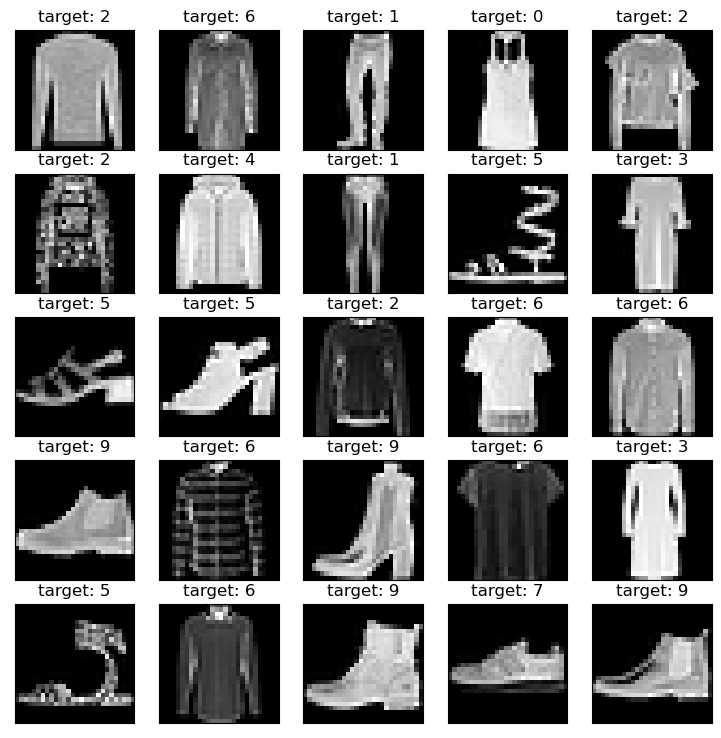

In [5]:
nrow = 5; ncol = 5
fig, axes = plt.subplots(nrow, ncol,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]})
for i, (feat, targ) in enumerate(train_dataset.unbatch().take(nrow*ncol)):
    ax = axes.flat[i]
    ax.imshow(feat.numpy(),cmap='gray')
    ax.set_title('target: {}'.format(targ.numpy()))

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Activities

1. (2 points) Baseline: Explore Convolutional Neural Networks with Fashion-MNIST. What is the accuracy of your CNN model? (1.5 points) Describe your Convolutional Neural Network architecture. (0.5 points) What are your conclusions about the baseline?

In [7]:
# # Use data augmentation
# data_augmentation = tf.keras.Sequential(
#     [
#           tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
#         , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05)
#         , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1)
#     ]
# )

In [8]:
# Inspect dataset
samples, targets = next(iter(train_dataset.take(1)))
INPUT_SHAPE = samples[0].shape + (1,)
print('Input shape: ',INPUT_SHAPE)

Input shape:  (28, 28, 1)


In [9]:
# MODEL
base_model = tf.keras.Sequential()

base_model.add(layers.Input(shape=INPUT_SHAPE))

base_model.add(layers.Conv2D(filters=32, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.MaxPool2D(pool_size=(2,2)))

base_model.add(layers.Conv2D(filters=64, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.MaxPool2D(pool_size=(2,2)))

base_model.add(layers.Conv2D(filters=128, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.Flatten())

base_model.add(layers.Dense(10, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.Activation('softmax'))

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1

In [10]:
# inputs = layers.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)
# outputs = base_model(x)
# model = tf.keras.Model(inputs, outputs)
# model.summary()
model = base_model

In [11]:
image_batch, label_batch = next(iter(train_dataset))
predicted_batch = model(image_batch)
print(predicted_batch.shape)

2022-11-13 21:00:28.837220: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


(16, 10)


2022-11-13 21:00:29.399471: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [12]:
print('CNN output format')
print(' '.join('{:^12s}'.format(str(el)) for el in range(10)))
for row in predicted_batch.numpy():
   print(' '.join('{:^12.3f}'.format(el) for el in row))

CNN output format
     0            1            2            3            4            5            6            7            8            9      
   0.000        0.000        0.999        0.000        0.000        0.000        0.000        0.000        0.001        0.000    
   0.000        0.000        0.861        0.000        0.000        0.000        0.000        0.000        0.138        0.000    
   0.000        0.000        1.000        0.000        0.000        0.000        0.000        0.000        0.000        0.000    
   0.000        0.000        0.779        0.000        0.000        0.000        0.000        0.000        0.221        0.000    
   0.000        0.000        1.000        0.000        0.000        0.000        0.000        0.000        0.000        0.000    
   0.000        0.000        1.000        0.000        0.000        0.000        0.000        0.000        0.000        0.000    
   0.000        0.000        1.000        0.000        0.000        0.00

In [13]:
print('Dataset label format')
label_batch.numpy()

Dataset label format


array([2, 6, 1, 0, 2, 2, 4, 1, 5, 3, 5, 5, 2, 6, 6, 9])

In [14]:
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

In [15]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [16]:
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

750/750 [==============================] - 5s 6ms/step - loss: 25.5062 - accuracy: 0.1068
initial loss: 25.51
initial accuracy: 0.11


In [17]:
initial_epochs = 5
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
3000/3000 [==============================] - 49s 16ms/step - loss: 0.4430 - accuracy: 0.8476 - val_loss: 0.3659 - val_accuracy: 0.8714
Epoch 2/5
3000/3000 [==============================] - 50s 17ms/step - loss: 0.3188 - accuracy: 0.8904 - val_loss: 0.3264 - val_accuracy: 0.8869
Epoch 3/5
3000/3000 [==============================] - 50s 17ms/step - loss: 0.2714 - accuracy: 0.9080 - val_loss: 0.3150 - val_accuracy: 0.8898
Epoch 4/5
3000/3000 [==============================] - 49s 16ms/step - loss: 0.2329 - accuracy: 0.9227 - val_loss: 0.3102 - val_accuracy: 0.8914
Epoch 5/5
3000/3000 [==============================] - 49s 16ms/step - loss: 0.2059 - accuracy: 0.9332 - val_loss: 0.3166 - val_accuracy: 0.8895


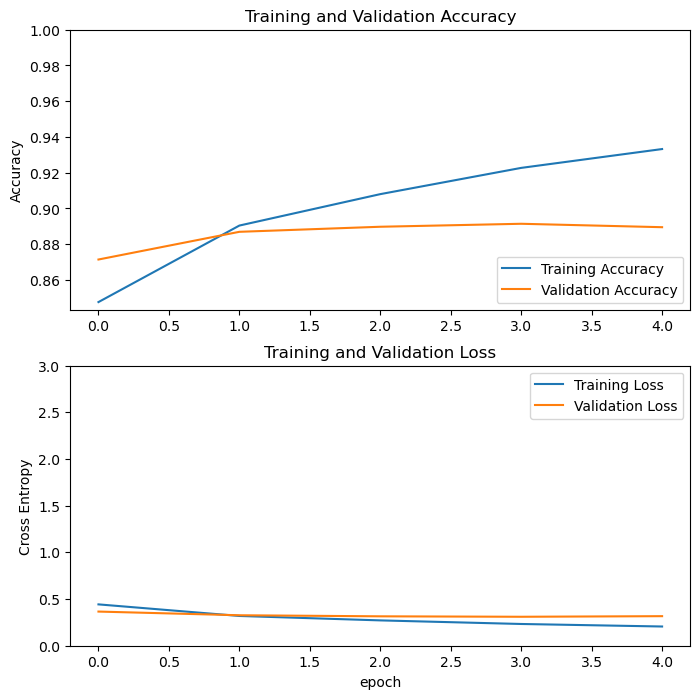

In [18]:
# Show the learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

625/625 [==============================] - 4s 7ms/step - loss: 0.3030 - accuracy: 0.8949
Test accuracy : 0.8949000239372253
pred [[2.34722197e-02 7.63134994e-06 2.65628303e-04 8.28873090e-06
  8.52810501e-07 9.75909650e-01 2.07443936e-05 2.47772550e-04
  6.67090862e-05 5.91068897e-07]
 [4.42733326e-05 8.57702958e-07 5.05086746e-07 2.81515190e-06
  7.46248716e-08 1.17059259e-04 2.78015978e-05 9.99450266e-01
  5.98461702e-06 3.50375572e-04]
 [2.10732664e-03 4.71483816e-07 7.69062899e-04 7.95910546e-06
  2.65195873e-02 8.12887322e-08 9.70594645e-01 1.82834707e-08
  4.23823622e-07 4.27659671e-07]
 [1.59406074e-04 7.88701186e-07 1.09169432e-05 7.06636129e-05
  3.78707296e-06 3.75782052e-04 1.82010306e-04 1.64540615e-02
  1.62108790e-05 9.82726455e-01]
 [6.14095144e-02 1.75429753e-03 1.02366991e-02 6.30766079e-02
  2.25486327e-03 3.38665973e-06 8.61173451e-01 2.16344069e-05
  2.43205386e-06 6.71623347e-05]
 [2.93887890e-04 1.00522411e-04 2.15200079e-03 3.51015624e-04
  9.95826542e-01 3.33518

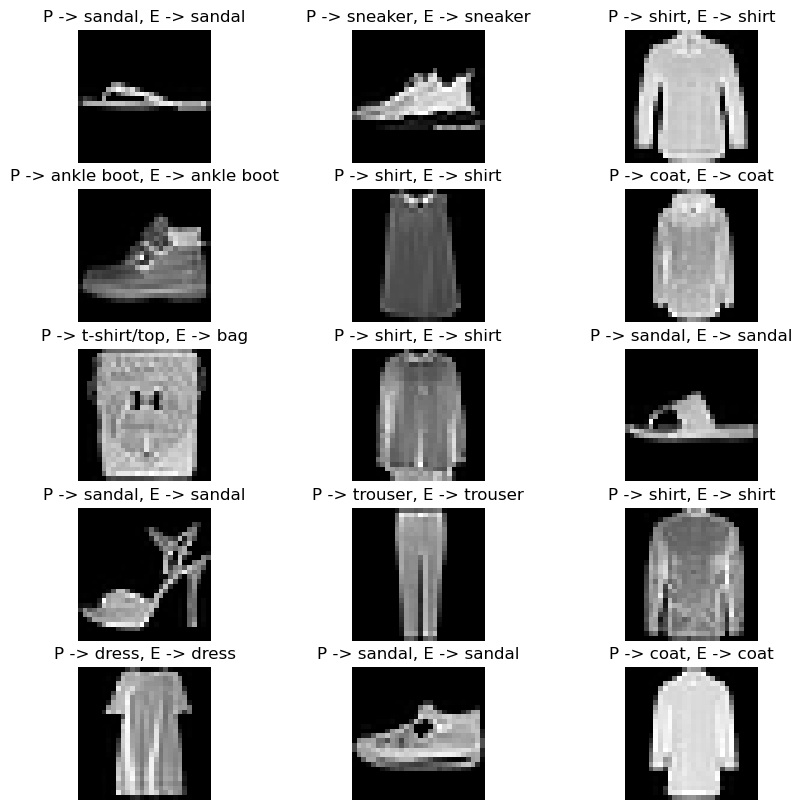

In [19]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('pred', predictions)


# Apply a sigmoid since our model returns logits
predicted_class = np.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)
print('Classes:\n', class_names)
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"), cmap='gray')
    plt.title('P -> {}, E -> {}'.format(class_names[predicted_class[i]], class_names[label_batch[i]]))
    plt.axis("off")

2. (2 points) Using PCA: Re-do the first experiment considering the PCA dimensionality reduction. (1.5 points) Consider two different energies (variance) for reducing the image dimensionality. (0.5 points) What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [5]:
from sklearn.decomposition import PCA
#n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset
pca = PCA(n_components=0.80)

In [6]:
# Download Fashion-MNIST
df = pd.read_csv("./fashion-mnist_train.csv.zip").sample(frac=1, random_state=123)
n_sample, n_feature = df.shape
train_df = df[:int(n_sample*0.8)]
valid_df = df[int(n_sample*0.8):]
testt_df = pd.read_csv("./fashion-mnist_test.csv.zip").sample(frac=1, random_state=123)

class_names = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

print('train shape {}, validation shape {}, teste shape {}'.format(train_df.shape, valid_df.shape, testt_df.shape))

train shape (48000, 785), validation shape (12000, 785), teste shape (10000, 785)


In [7]:
sample_train_df = train_df
target_train_df = sample_train_df.pop('label')

sample_valid_df = valid_df
target_valid_df = sample_valid_df.pop('label')

sample_testt_df = testt_df
target_testt_df = sample_testt_df.pop('label')

In [8]:
pcas = {14*14 : PCA(n_components=14*14), 7*7 : PCA(n_components=7*7)}

In [9]:
for key in pcas:
    pca = pcas[key]
    pca.fit(sample_train_df)
    print('Num. of PCA componentes {:3d} and variance {:0.3f}'.format(key, sum(pca.explained_variance_ratio_)))

Num. of PCA componentes 196 and variance 0.952
Num. of PCA componentes  49 and variance 0.861


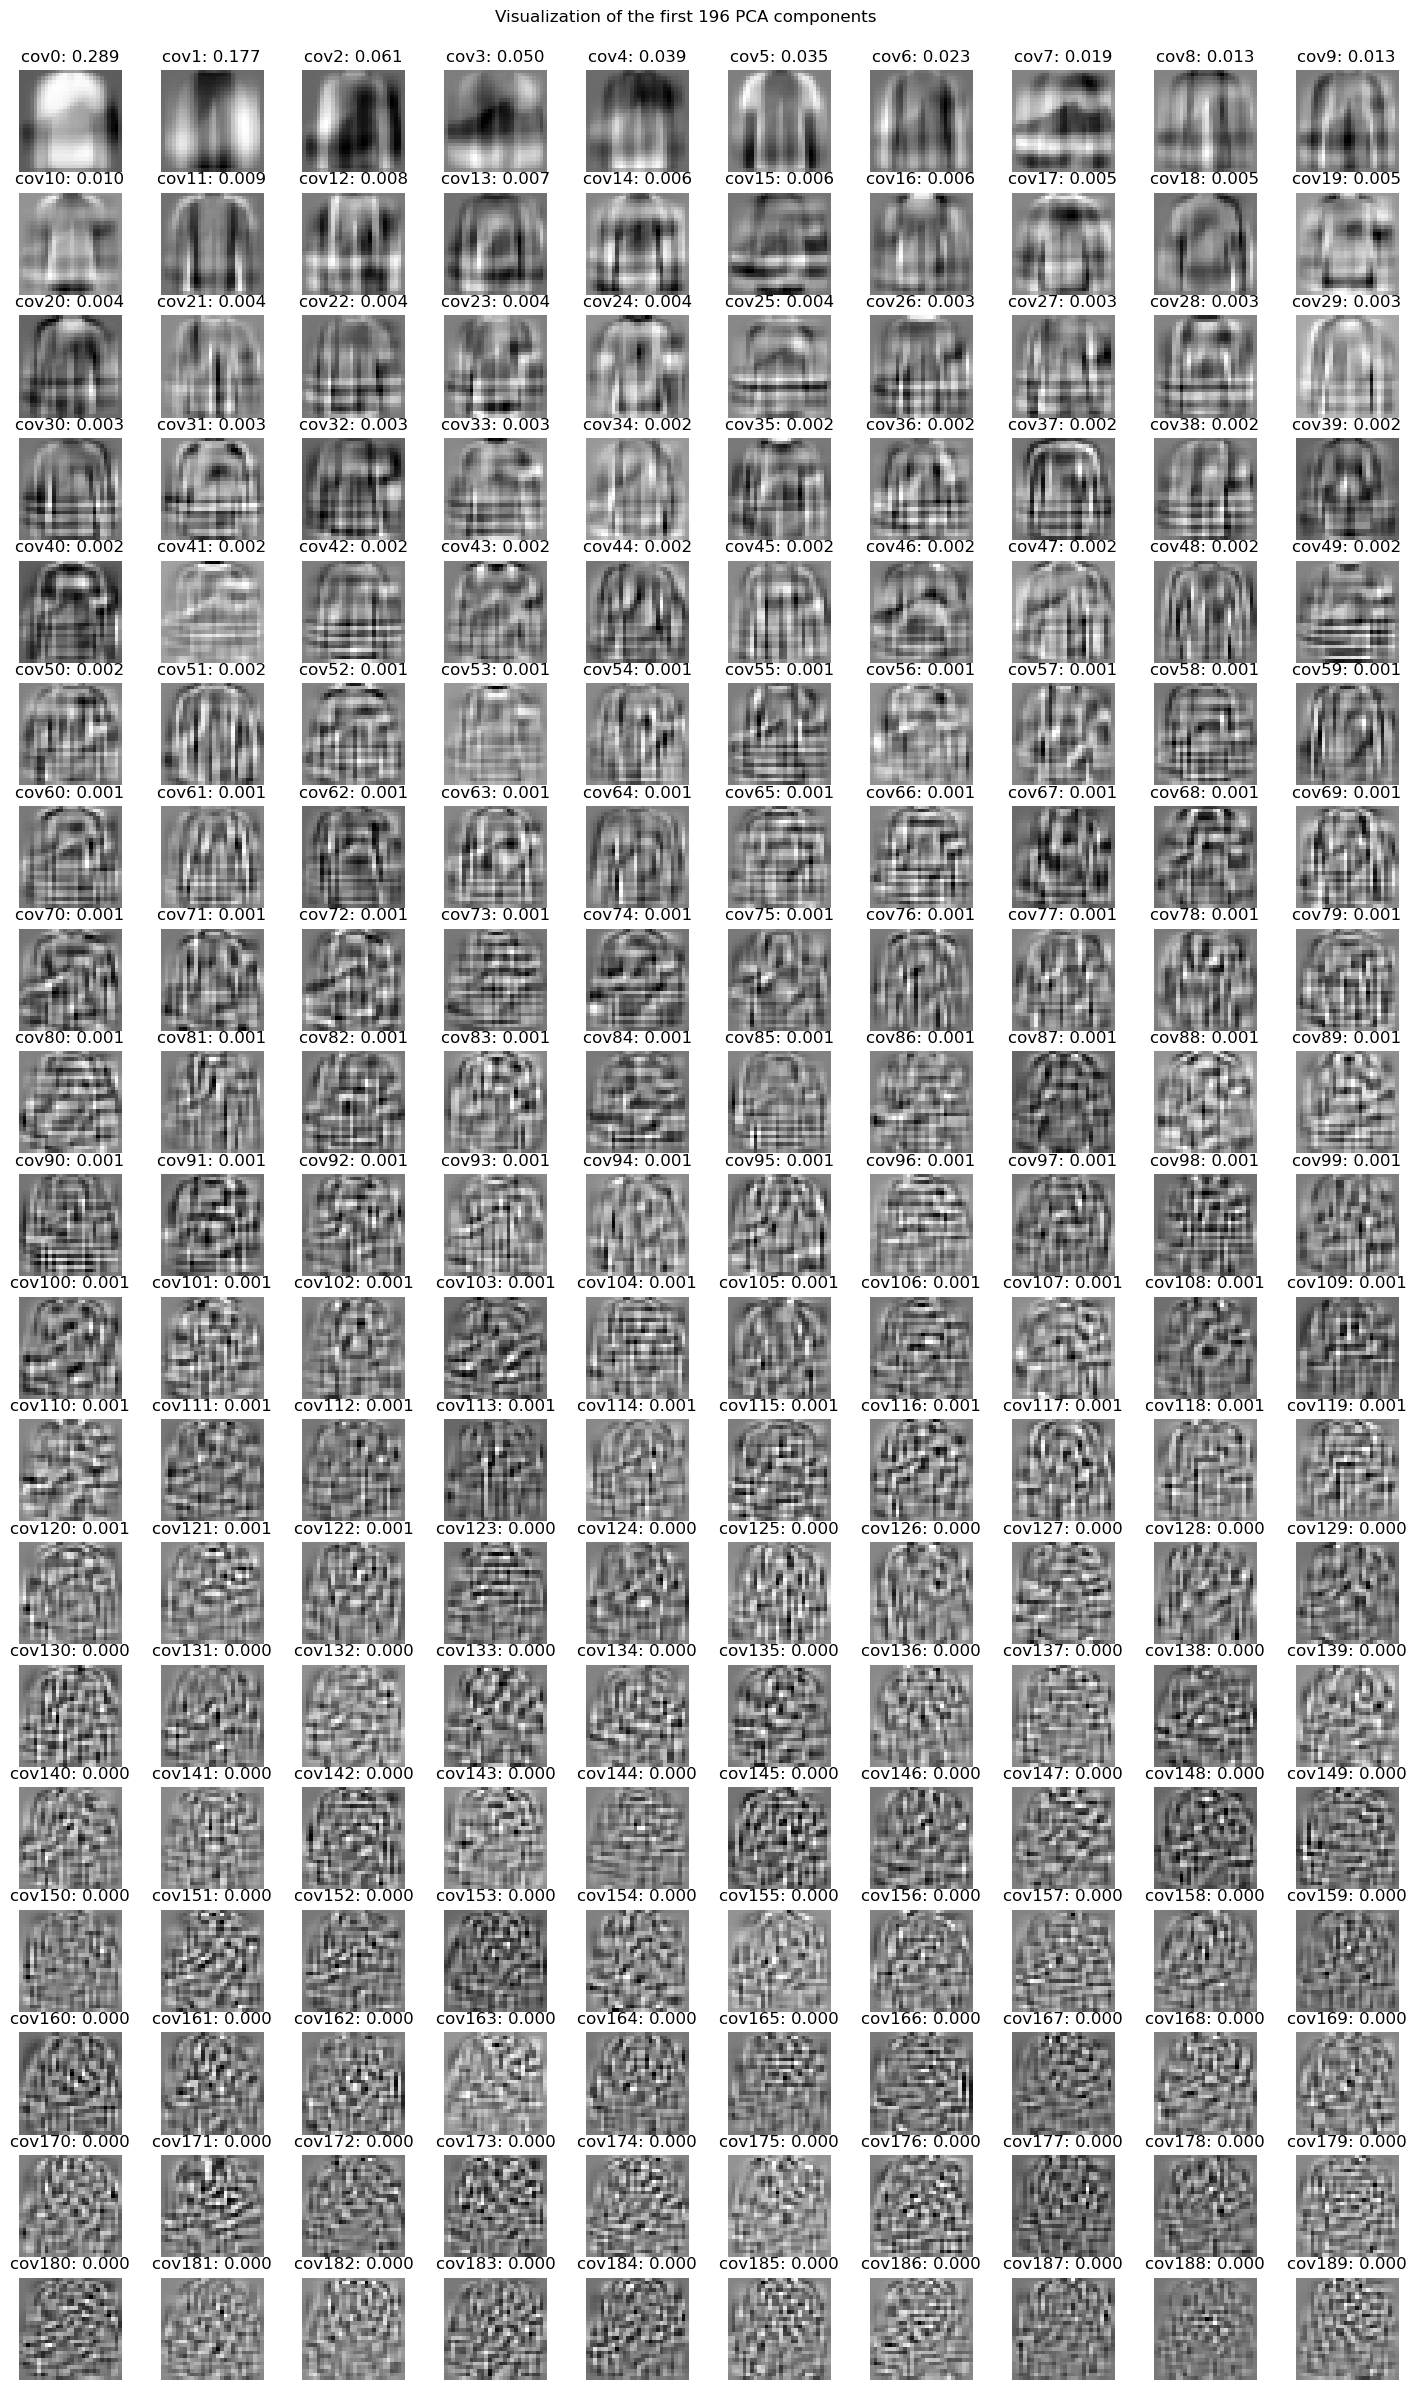

In [10]:
pca = pcas[14*14]
ncol = 10
nrow = int(14*14/10)
fig, axes = plt.subplots(nrow, ncol, figsize=(18,30))   
fig.suptitle('Visualization of the first 196 PCA components', y=0.90)
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(pca.components_[i].reshape(28,28),cmap='gray')   
    ax.set_title('cov{}: {:0.3f}'.format(i, pca.explained_variance_ratio_[i]))

In [13]:
BATCH_SIZE = 16
key = 14*14
dim = int(np.sqrt(key))

component_sample_train_df = pcas[key].transform(sample_train_df)

component_sample_valid_df = pcas[key].transform(sample_valid_df)

component_sample_testt_df = pcas[key].transform(sample_testt_df)

samples = component_sample_train_df
target  = target_train_df
train_dataset = tf.data.Dataset.from_tensor_slices((samples.reshape(-1, dim, dim), target.values))
train_dataset = train_dataset.batch(BATCH_SIZE)

samples = component_sample_valid_df
target  = target_valid_df
validation_dataset = tf.data.Dataset.from_tensor_slices((samples.reshape(-1, dim, dim), target.values))
validation_dataset = validation_dataset.batch(BATCH_SIZE)

samples = component_sample_testt_df
target  = target_testt_df
test_dataset = tf.data.Dataset.from_tensor_slices((samples.reshape(-1, dim, dim), target.values))
test_dataset = test_dataset.batch(BATCH_SIZE)

print('train batches {}, validation batches {}, teste batches {}'.format(train_dataset.cardinality(), validation_dataset.cardinality(), test_dataset.cardinality()))

train batches 3000, validation batches 750, teste batches 625


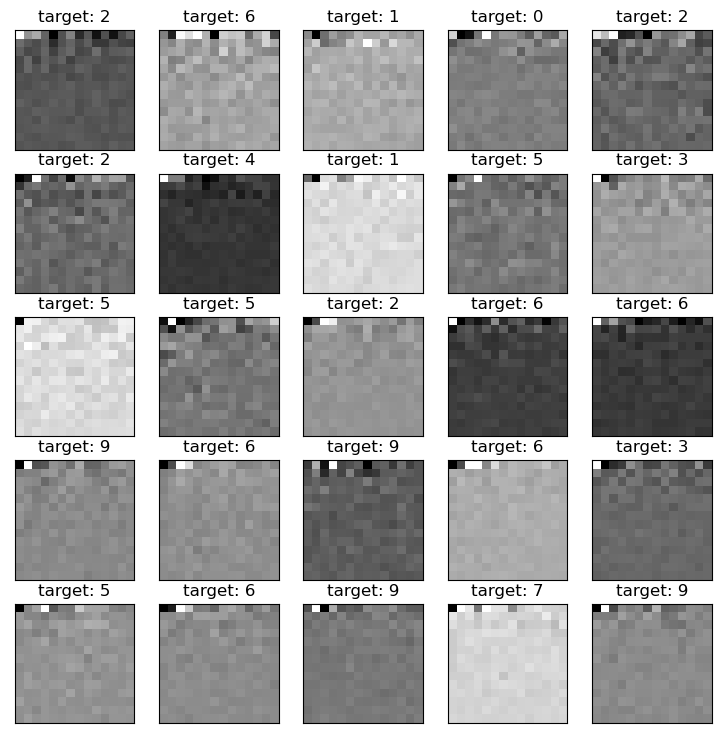

In [14]:
nrow = 5; ncol = 5
fig, axes = plt.subplots(nrow, ncol,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]})
for i, (feat, targ) in enumerate(train_dataset.unbatch().take(nrow*ncol)):
    ax = axes.flat[i]
    ax.imshow(feat.numpy(),cmap='gray')
    ax.set_title('target: {}'.format(targ.numpy()))

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
# Inspect dataset
samples, targets = next(iter(train_dataset.take(1)))
INPUT_SHAPE = samples[0].shape + (1,)
print('Input shape: ',INPUT_SHAPE)

Input shape:  (14, 14, 1)


In [17]:
# MODEL
base_model = tf.keras.Sequential()

base_model.add(layers.Input(shape=INPUT_SHAPE))

base_model.add(layers.Conv2D(filters=32, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.MaxPool2D(pool_size=(2,2)))

base_model.add(layers.Conv2D(filters=64, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.MaxPool2D(pool_size=(2,2)))

base_model.add(layers.Conv2D(filters=128, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.Flatten())

base_model.add(layers.Dense(10, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.Activation('softmax'))

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          1

In [18]:
# inputs = layers.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)
# outputs = base_model(x)
# model = tf.keras.Model(inputs, outputs)
# model.summary()
model = base_model
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=METRICS)
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

750/750 [==============================] - 4s 5ms/step - loss: 14.8985 - accuracy: 0.1149
initial loss: 14.90
initial accuracy: 0.11


In [19]:
initial_epochs = 5
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
3000/3000 [==============================] - 57s 19ms/step - loss: 0.5733 - accuracy: 0.7992 - val_loss: 0.4357 - val_accuracy: 0.8474
Epoch 2/5
3000/3000 [==============================] - 62s 21ms/step - loss: 0.4139 - accuracy: 0.8535 - val_loss: 0.4127 - val_accuracy: 0.8551
Epoch 3/5
3000/3000 [==============================] - 76s 25ms/step - loss: 0.3668 - accuracy: 0.8721 - val_loss: 0.4047 - val_accuracy: 0.8558
Epoch 4/5
3000/3000 [==============================] - 67s 22ms/step - loss: 0.3347 - accuracy: 0.8819 - val_loss: 0.3807 - val_accuracy: 0.8639
Epoch 5/5
3000/3000 [==============================] - 69s 23ms/step - loss: 0.3083 - accuracy: 0.8928 - val_loss: 0.3699 - val_accuracy: 0.8764


In [20]:
BATCH_SIZE = 16
key = 7*7
dim = int(np.sqrt(key))

component_sample_train_df = pcas[key].transform(sample_train_df)

component_sample_valid_df = pcas[key].transform(sample_valid_df)

component_sample_testt_df = pcas[key].transform(sample_testt_df)

samples = component_sample_train_df
target  = target_train_df
train_dataset = tf.data.Dataset.from_tensor_slices((samples.reshape(-1, dim, dim), target.values))
train_dataset = train_dataset.batch(BATCH_SIZE)

samples = component_sample_valid_df
target  = target_valid_df
validation_dataset = tf.data.Dataset.from_tensor_slices((samples.reshape(-1, dim, dim), target.values))
validation_dataset = validation_dataset.batch(BATCH_SIZE)

samples = component_sample_testt_df
target  = target_testt_df
test_dataset = tf.data.Dataset.from_tensor_slices((samples.reshape(-1, dim, dim), target.values))
test_dataset = test_dataset.batch(BATCH_SIZE)

print('train batches {}, validation batches {}, teste batches {}'.format(train_dataset.cardinality(), validation_dataset.cardinality(), test_dataset.cardinality()))

train batches 3000, validation batches 750, teste batches 625


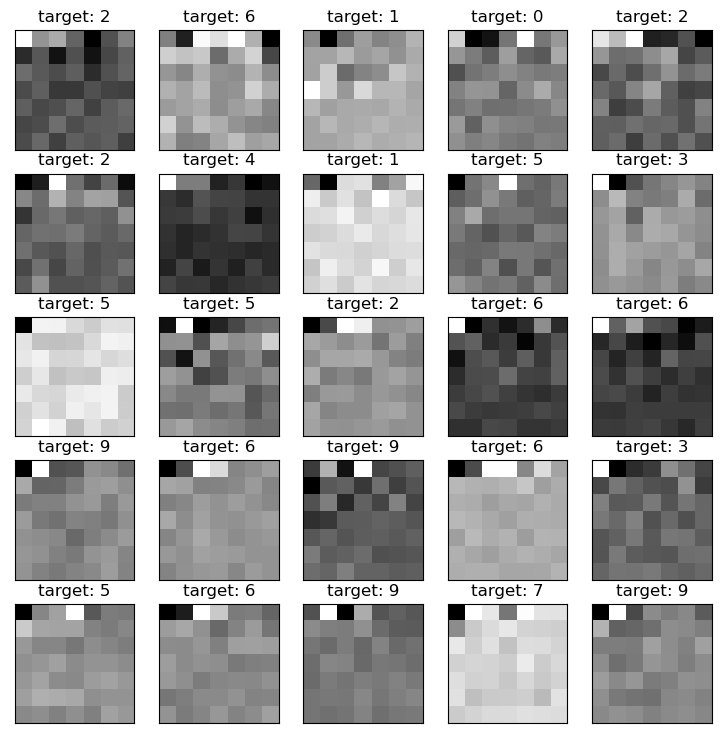

In [21]:
nrow = 5; ncol = 5
fig, axes = plt.subplots(nrow, ncol,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]})
for i, (feat, targ) in enumerate(train_dataset.unbatch().take(nrow*ncol)):
    ax = axes.flat[i]
    ax.imshow(feat.numpy(),cmap='gray')
    ax.set_title('target: {}'.format(targ.numpy()))

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [24]:
# Inspect dataset
samples, targets = next(iter(train_dataset.take(1)))
INPUT_SHAPE = samples[0].shape + (1,)
print('Input shape: ',INPUT_SHAPE)

Input shape:  (7, 7, 1)


In [25]:
# MODEL
base_model = tf.keras.Sequential()

base_model.add(layers.Input(shape=INPUT_SHAPE))

base_model.add(layers.Conv2D(filters=32, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.MaxPool2D(pool_size=(2,2)))

base_model.add(layers.Conv2D(filters=64, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.MaxPool2D(pool_size=(2,2)))

base_model.add(layers.Conv2D(filters=128, kernel_size=7, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Activation('relu'))
base_model.add(layers.Dropout(0.1))

base_model.add(layers.Flatten())

base_model.add(layers.Dense(10, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
base_model.add(layers.Activation('softmax'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          1600      
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 32)         128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 7, 7, 32)          0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 64)         

In [26]:
# inputs = layers.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)
# outputs = base_model(x)
# model = tf.keras.Model(inputs, outputs)
# model.summary()
model = base_model
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=METRICS)
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

750/750 [==============================] - 2s 3ms/step - loss: 3.5896 - accuracy: 0.1140
initial loss: 3.59
initial accuracy: 0.11


In [27]:
initial_epochs = 5
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
3000/3000 [==============================] - 29s 9ms/step - loss: 0.6858 - accuracy: 0.7671 - val_loss: 0.4714 - val_accuracy: 0.8367
Epoch 2/5
3000/3000 [==============================] - 28s 9ms/step - loss: 0.5006 - accuracy: 0.8235 - val_loss: 0.4233 - val_accuracy: 0.8519
Epoch 3/5
3000/3000 [==============================] - 31s 10ms/step - loss: 0.4568 - accuracy: 0.8385 - val_loss: 0.4100 - val_accuracy: 0.8519
Epoch 4/5
3000/3000 [==============================] - 28s 9ms/step - loss: 0.4329 - accuracy: 0.8471 - val_loss: 0.3866 - val_accuracy: 0.8638
Epoch 5/5
3000/3000 [==============================] - 28s 9ms/step - loss: 0.4117 - accuracy: 0.8541 - val_loss: 0.3815 - val_accuracy: 0.8635


# AUTO-ENCODER

In [36]:
# Download Fashion-MNIST
df = pd.read_csv("./fashion-mnist_train.csv.zip").sample(frac=1, random_state=123)
n_sample, n_feature = df.shape
train_df = df[:int(n_sample*0.8)]
valid_df = df[int(n_sample*0.8):]
testt_df = pd.read_csv("./fashion-mnist_test.csv.zip").sample(frac=1, random_state=123)

class_names = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

print('train shape {}, validation shape {}, teste shape {}'.format(train_df.shape, valid_df.shape, testt_df.shape))

train shape (48000, 785), validation shape (12000, 785), teste shape (10000, 785)


In [37]:
BATCH_SIZE = 16

samples = train_df
target  = samples.pop('label')
train_dataset = tf.data.Dataset.from_tensor_slices((samples.values.reshape(-1, 28, 28), samples.values.reshape(-1, 28, 28)))
train_dataset = train_dataset.batch(BATCH_SIZE)

samples = valid_df
target  = samples.pop('label')
validation_dataset = tf.data.Dataset.from_tensor_slices((samples.values.reshape(-1, 28, 28), samples.values.reshape(-1, 28, 28)))
validation_dataset = validation_dataset.batch(BATCH_SIZE)

samples = testt_df
target  = samples.pop('label')
test_dataset = tf.data.Dataset.from_tensor_slices((samples.values.reshape(-1, 28, 28), samples.values.reshape(-1, 28, 28)))
test_dataset = test_dataset.batch(BATCH_SIZE)

print('train batches {}, validation batches {}, teste batches {}'.format(train_dataset.cardinality(), validation_dataset.cardinality(), test_dataset.cardinality()))

train batches 3000, validation batches 750, teste batches 625


In [38]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [57]:
# MODEL
encoder = tf.keras.Sequential()

encoder.add(layers.Input(shape=(28,28,1)))
encoder.add(layers.Flatten())
encoder.add(layers.Dense(28*28, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
encoder.add(layers.Activation('relu'))
encoder.add(layers.Dropout(0.1))

encoder.add(layers.Dense(20*20, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
encoder.add(layers.Activation('relu'))
encoder.add(layers.Dropout(0.1))

encoder.add(layers.Dense(12*12, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
encoder.add(layers.Activation('relu'))
encoder.add(layers.Dropout(0.1))

encoder.add(layers.Dense(4*4, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
encoder.add(layers.Activation('relu'))

encoder.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_56 (Dense)            (None, 784)               615440    
                                                                 
 activation_62 (Activation)  (None, 784)               0         
                                                                 
 dropout_48 (Dropout)        (None, 784)               0         
                                                                 
 dense_57 (Dense)            (None, 400)               314000    
                                                                 
 activation_63 (Activation)  (None, 400)               0         
                                                                 
 dropout_49 (Dropout)        (None, 400)             

In [58]:
decoder = tf.keras.Sequential()

decoder.add(layers.Input(shape=(16,)))
decoder.add(layers.Flatten())

decoder.add(layers.Dense(12*12, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
decoder.add(layers.Activation('relu'))
decoder.add(layers.Dropout(0.1))

decoder.add(layers.Dense(20*20, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
decoder.add(layers.Activation('relu'))
decoder.add(layers.Dropout(0.1))

decoder.add(layers.Dense(28*28, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4)))
decoder.add(layers.Activation('relu'))

decoder.add(layers.Reshape((28,28)))

decoder.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 16)                0         
                                                                 
 dense_60 (Dense)            (None, 144)               2448      
                                                                 
 activation_66 (Activation)  (None, 144)               0         
                                                                 
 dropout_51 (Dropout)        (None, 144)               0         
                                                                 
 dense_61 (Dense)            (None, 400)               58000     
                                                                 
 activation_67 (Activation)  (None, 400)               0         
                                                                 
 dropout_52 (Dropout)        (None, 400)             

In [59]:
inputs = layers.Input(shape=(28,28,1))
x = encoder(inputs)
outputs = decoder(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 sequential_15 (Sequential)  (None, 16)                989504    
                                                                 
 sequential_16 (Sequential)  (None, 28, 28)            374832    
                                                                 
Total params: 1,364,336
Trainable params: 1,364,336
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.MeanSquaredError())


In [61]:
initial_epochs = 5
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
3000/3000 [==============================] - 44s 15ms/step - loss: 2549.6379 - val_loss: 1651.0927
Epoch 2/5
3000/3000 [==============================] - 43s 14ms/step - loss: 1761.9846 - val_loss: 1426.7871
Epoch 3/5
3000/3000 [==============================] - 43s 14ms/step - loss: 1564.2887 - val_loss: 1274.5742
Epoch 4/5
3000/3000 [==============================] - 47s 16ms/step - loss: 1455.4216 - val_loss: 1279.2175
Epoch 5/5
3000/3000 [==============================] - 44s 15ms/step - loss: 1381.4730 - val_loss: 1183.8323


In [62]:
image_batch, label_batch = next(iter(train_dataset))
predicted_batch = model(image_batch)

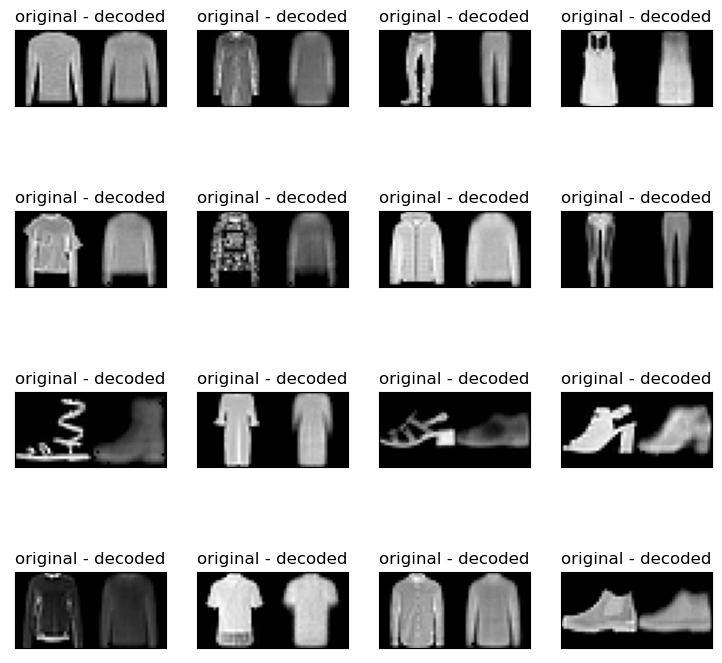

In [77]:
fig, axes = plt.subplots(4, 4,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]})
for i in range(16):
    ori = image_batch[i,:,:].numpy()
    dec = predicted_batch[i,:,:].numpy()    
    together = np.concatenate((ori, dec), axis=1)
    ax = axes.flat[i]
    ax.imshow(together,cmap='gray')
    ax.set_title('original - decoded')